In [1]:
import numpy as np
import pandas as pd
import os
import pymongo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
train_on_gpu = torch.cuda.is_available()
from sklearn.decomposition import PCA
from sklearn import preprocessing
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [3]:
AAPL_df = pd.read_csv('collected_df.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
# AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Close,Date,Volume,Adj Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,^VIX_Close,...,BACTSAMFRBDAL,IR,IQ,PPIACO,CPIAUCSL,CPILFESL,MICH,CSCICP03USM665S,Grow,News_Score
0,27.332500,2015-01-02,212818400,24.565697,17832.990234,4726.810059,2058.199951,960.280029,10830.919922,17.790001,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,False,0.500000
1,26.562500,2015-01-05,257142000,23.873644,17501.650391,4652.569824,2020.579956,943.780029,10607.679688,19.920000,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,False,0.500375
2,26.565001,2015-01-06,263188400,23.875887,17371.640625,4592.740234,2002.609985,935.020020,10514.870117,21.120001,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.719541
3,26.937500,2015-01-07,160423600,24.210682,17584.519531,4650.470215,2025.900024,946.880005,10627.129883,19.309999,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.074792
4,27.972500,2015-01-08,237458000,25.140909,17907.869141,4736.189941,2062.139893,964.159973,10800.540039,17.010000,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.996247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,131.860001,2022-12-23,63814900,131.658981,33203.929688,10497.860352,3844.820068,2165.620117,15188.450195,20.870001,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.696560
2003,130.029999,2022-12-27,69007800,129.831772,33241.558594,10353.230469,3829.250000,2144.899902,15218.259766,21.650000,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.312938
2004,126.040001,2022-12-28,85438400,125.847855,32875.710938,10213.290039,3783.219971,2117.199951,15037.320312,22.139999,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.175638
2005,129.610001,2022-12-29,75703700,129.412415,33220.800781,10478.089844,3849.280029,2163.790039,15241.209961,21.440001,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,True,0.930547


In [4]:
from sklearn.preprocessing import MinMaxScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
    
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df,scaler
        
def split_train_test_data(df, lookback, pred_length=1, use_PCA= False, num_features = None):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
    print(len(res_list))
    data = []
    res_data = []
    if num_features == None:
        num_feature = len(df.columns.tolist())-1
    if use_PCA:
        pca_fit = PCA(num_features)
        df_list = pca_fit.fit_transform(df_list)
        df_list=scaler.fit_transform(df_list)

    for index in range(len(df_list) - lookback - pred_length + 1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
        the_list= np.transpose(the_list)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + pred_length])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return x_train, y_train,x_val,y_val, x_test, y_test

In [5]:
class MyDataLoader(Dataset):
    def __init__(self, x_list, y_list):

        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    

    def __getitem__(self, idx):
        x_data = self.x_list[idx]
        y_data = self.y_list[idx]
        sample = {'Data': x_data, 'Labels': y_data}

        return sample

In [7]:
class AttentionalLSTM(nn.Module):
    def __init__(self, input_size, qkv, hidden_size, num_layers, output_size, bidirectional=False):
        super(AttentionalLSTM, self).__init__()

        self.input_size = input_size
        self.qkv = qkv
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.query = nn.Linear(input_size, qkv)
        self.key = nn.Linear(input_size, qkv)
        self.value = nn.Linear(input_size, qkv)

        self.attn = nn.Linear(qkv, input_size)
        self.scale = math.sqrt(qkv)
        self.activation =  nn.Tanh()
        self.out_activation = nn.Tanhshrink()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.1)

        if bidirectional:
            self.fc1 = nn.Linear(hidden_size * 2, output_size)
            # self.fc2 = nn.Linear(hidden_size, output_size)
        else:
            self.fc1 = nn.Linear(hidden_size*self.num_layers, hidden_size)
            self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batchsize = x.shape[0]
        Q, K, V = self.query(x), self.key(x), self.value(x)

        dot_product = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        scores = torch.softmax(dot_product, dim=-1)
        scaled_x = torch.matmul(scores, V) + x
#         scaled_x = torch.unsqueeze(scaled_x, -1)
#         print(x.size(), scaled_x.size())

        out = self.attn(scaled_x) + x
#         print(out.size())
        out, (h_n, c_n) = self.lstm(out)
#         encoded_out = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout(out)
        # out = self.activation(out)   
        out_rate = self.fc2(out)
        out_rate = self.out_activation(out_rate)
#         print(x.size(), out_rate.size())
        x = torch.unsqueeze(x[:,0,-1], 1)
        out_rate = out_rate + x
#         print(x.size(), out_rate.size())
#         print(out_rate.size(), x[:,-1,0].size())
        return out_rate
        # return x + out_rate * x

In [68]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.embedding = nn.Linear(input_size, input_size)
#         self.linear_1 = nn.Linear(input_size, hidden_layer_size)
#         self.relu = nn.ReLU()
        self.gru_1 = nn.GRU(input_size, hidden_layer_size*2, num_layers=num_layers, batch_first=True,bidirectional =False)
#         self.lstm_2 = nn.LSTM(hidden_layer_size*2, hidden_size=self.hidden_layer_size*4, num_layers=num_layers, batch_first=True,bidirectional =True)
        
#         
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(self.hidden_layer_size*2*num_layers, 256)
#         self.linear_1 = nn.Linear(self.hidden_layer_size*4, output_size)
        
        self.linear_2 = nn.Linear(256, output_size)
        
    def forward(self, x):
        batchsize = x.shape[0]
#         print(self.output_size)
        # layer 1
        x = self.embedding(x)
        out, h_n = self.gru_1(x)
#         print(x.size())
        
        # LSTM layer
#         x, (h_n, c_n) = self.lstm_2(x)
#         print(x.size())
#         print(lstm_out.size())
        # reshape output from hidden cell into [batch, features] for `linear_2`
#         out = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        out = out[:, -1, :]
#         x = x.reshape(batchsize, -1)
        
#         print(x.size())
        # layer 2
        
        out = self.linear_1(out)
        out = self.dropout(out)
        out = self.linear_2(out)
        x = torch.unsqueeze(x[:,0,-1], 1)
        out_rate = out + x
#         print(predictions.size())
        return out_rate

In [76]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.embedding = nn.Linear(input_size, input_size)
#         print(input_size)
#         self.relu = nn.ReLU()
        self.lstm_1 = nn.LSTM(input_size, hidden_layer_size*2, num_layers=num_layers, batch_first=True,bidirectional =False)
#         self.lstm_2 = nn.LSTM(hidden_layer_size*2, hidden_size=self.hidden_layer_size*4, num_layers=num_layers, batch_first=True,bidirectional =True)
        
#         
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(self.hidden_layer_size*2*num_layers, 256)
#         self.linear_1 = nn.Linear(self.hidden_layer_size*4, output_size)
        
        self.linear_2 = nn.Linear(256, output_size)
        
    def forward(self, x):
        batchsize = x.shape[0]
#         print(self.output_size)
        # layer 1
#         print(x.size())
        x = self.embedding(x)
        out, (h_n, c_n) = self.lstm_1(x)
#         print(x.size())
        
        # LSTM layer
#         x, (h_n, c_n) = self.lstm_2(x)
#         print(x.size())
#         print(lstm_out.size())
        # reshape output from hidden cell into [batch, features] for `linear_2`
#         out = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        out = out[:, -1, :]
#         x = x.reshape(batchsize, -1)
        
#         print(x.size())
        # layer 2
        
        out = self.linear_1(out)
        out = self.dropout(out)
        out = self.linear_2(out)
        x = torch.unsqueeze(x[:,0,-1], 1)
        out_rate = out + x
#         print(predictions.size())
        return out_rate

In [77]:
def train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma):
    n_epochs = 150
    last_epochs=0
    var_value = 0.0
    train_loss_res=[]
    valid_loss_res=[]
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for i_batch, sample_batched in enumerate(train_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data=data_batch.float()
            target = labels_batch.float()
#             print(data.size())
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()

            optimizer.zero_grad()
            output = model(data)
#             print(output.size(),target.size(), var.size())
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            # criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)


        model.eval()
        for i_batch, sample_batched in enumerate(val_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data = data_batch.float()
            target = labels_batch.float()
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()
            output = model(data)

            # loss = criterion(output, target)
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            valid_loss += loss.item()*data.size(0)

    #     print(len(train_loader.sampler))
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        train_loss_res.append(train_loss)
        valid_loss_res.append(valid_loss)

        if valid_loss <= valid_loss_min:
            last_epochs=epoch
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss
        if epoch-last_epochs>50:
            break
    return model

In [78]:
def combine_values(the_list,last=True):
    res=[]
    for i in range(len(the_list)):
        if last:
            if i==len(the_list)-1:
                for ii in range(len(the_list[i])):
                    res.append(the_list[i][ii])
            else:
                res.append(the_list[i][0])
        else:
            res.append(the_list[i][0])
    res=np.array(res)
    return res

In [79]:
def forecast_accuracy(forecast, actual):
    print(forecast.shape)
#     print(forecast[0], actual[0])
    ae = np.sum(np.abs(forecast - actual))    # AE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'ae':ae, 'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

def denormalise(the_df,thevalue):
    themax=the_df['Close'].max()
    themin=the_df['Close'].min()
    therange = themax - themin
    thevalue = thevalue*therange+themin
#     print(thevalue)
    return thevalue

In [80]:
def evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, the_df, lookback, pred_length, is_stock =  True):
    actual_values = np.concatenate((y_train.detach().cpu().numpy(),  y_val.detach().cpu().numpy()), axis=0)[:,0]
    actual_values = np.concatenate((actual_values,y_test.detach().cpu().numpy()[:,0]), axis=0)
    actual_values = denormalise(the_df,actual_values)
    print(actual_values.shape)
    actual = actual_values
#     combine_values(actual_values)
    print(actual.shape)
    devide = 16
    train_len = len(x_train)//devide

    # actual =  np.concatenate(actual)
    if train_on_gpu:
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_train[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_train[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            
            if i ==0:
                predict = temp_predict[:,0]
                predict_train = temp_predict
            else:     
                predict = np.concatenate((predict, temp_predict[:,0]), axis=None)
                predict_train = np.concatenate((predict_train, temp_predict), axis=0)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_val[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_val[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            
            if i ==0:
                val_predict = temp_predict[:,0]
                predict_val = temp_predict
            else:     
                val_predict = np.concatenate((val_predict, temp_predict[:,0]), axis=None)
                predict_val = np.concatenate((predict_val, temp_predict), axis=0)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_test[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_test[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            
            if i ==0:
                test_predict = temp_predict[:,0]
                predict_test = temp_predict
            else:     
                test_predict = np.concatenate((test_predict, temp_predict[:,0]), axis=None)
                predict_test = np.concatenate((predict_test, temp_predict), axis=0)
                
#         val_predict = model(x_val.cuda()).detach().cpu().numpy()
#         test_predict = model(x_test.cuda()).detach().cpu().numpy()
    else:
        predict = model(x_train).detach().numpy()
        val_predict = model(x_val).detach().numpy()
        test_predict = model(x_test).detach().numpy()
    predict = denormalise(the_df,predict)
    val_predict = denormalise(the_df,val_predict)
    test_predict = denormalise(the_df,test_predict)
    print('predict',predict.shape)   
    train_num = len(predict)
    train_sum = 0 
    for i in range(train_num):
        train_sum += np.abs(actual_values[i]-predict[i])
    print('Train Loss:',train_sum.sum()/train_num)

    val_num = len(val_predict)
    val_sum = 0 
    for i in range(val_num):
        val_sum += np.abs(actual_values[train_num+i]-val_predict[i])
    print('Val Loss:',val_sum.sum()/val_num)

    test_num = len(test_predict)
    test_sum = 0 
    for i in range(test_num):
        test_sum += np.abs(actual_values[val_num+train_num+i]-test_predict[i])
    print('Test Loss:',test_sum.sum()/test_num)
#     predict=combine_values(predict,True)
    print('predict',predict.shape)
#     val_predict=combine_values(val_predict,True)
    print('val_predict',val_predict.shape)
    
#     val_predict = np.append(val_predict,test_predict[0])
#     print(len(val_predict))
    os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
    
    print('test_predict',test_predict.shape)
    the_df['Date'] = pd.to_datetime(the_df['Date'], format='%Y-%m-%d')

    data_date = the_df['Date'].tolist()
    data_date = np.array(data_date[lookback:-pred_length+1])
        # data_len = len(data_date)
    fig = figure(figsize=(25, 5), dpi=300)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, actual, label="Actual Prices", color='b')
    plt.plot(data_date[:len(predict)], predict, label="Predicted Training Prices", color='r')
    plt.plot(data_date[len(predict):len(predict)+len(val_predict)], val_predict, label="Predicted Validation Prices", color='g')
    plt.plot(data_date[len(predict)+len(val_predict):], test_predict, label="Predicted Testing Prices", color='k')
    plt.title("Predicted Close Prices and Actual Close Prices")

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.savefig('Data_Pred.png')
    plt.show()

    
    torch.cuda.empty_cache()
    print(len(actual_values[:train_num]),len(actual_values[train_num:val_num+train_num]),len(actual_values[val_num+train_num:]))
    print(len(predict),len(val_predict),len(test_predict))
    print(len(x_val))
    print(y_train.detach().numpy().shape)

    print(forecast_accuracy(y_train.detach().numpy(),predict_train))
    print(forecast_accuracy(y_val.detach().numpy(),predict_val))
    print(forecast_accuracy(y_test.detach().numpy(),predict_test))

2007
[[0.0297789  0.02494904 0.02496473 0.02730125 0.03379333 0.03398151
  0.02965345 0.03117454 0.03051593 0.02584288 0.02454132 0.02882234
  0.03012389 0.03459308 0.0355026 ]
 [0.28946222 0.3616941  0.37154761 0.20407712 0.32961611 0.29268827
  0.26629644 0.37998789 0.26177124 0.33384993 0.45443935 0.26792022
  0.25928961 0.29331992 0.2455282 ]
 [0.02304532 0.0187146  0.01872864 0.02082371 0.02664488 0.02681364
  0.02293284 0.02429674 0.02370618 0.01951604 0.01834897 0.02218759
  0.02335466 0.02736203 0.02817752]
 [0.10278454 0.08711055 0.08096045 0.09103066 0.10632668 0.09826119
  0.09369489 0.09241008 0.08358347 0.07855123 0.08757981 0.08775295
  0.08960015 0.10188528 0.09519728]
 [0.0390116  0.03271504 0.02764069 0.03253697 0.03980714 0.03708293
  0.03374469 0.03347244 0.03159126 0.02578155 0.03117229 0.03290844
  0.03397453 0.04101233 0.04164674]
 [0.07721029 0.06453287 0.05847723 0.06632566 0.07853799 0.07269808
  0.06712094 0.06535851 0.06139555 0.05512761 0.06414199 0.06519676

Epoch: 0 	Training Loss: 15.770540 	Validation Loss: 25.489737
Validation loss decreased (inf --> 25.489737).  Saving model ...
Epoch: 1 	Training Loss: 5.992682 	Validation Loss: 9.959202
Validation loss decreased (25.489737 --> 9.959202).  Saving model ...
Epoch: 2 	Training Loss: 3.994067 	Validation Loss: 4.050859
Validation loss decreased (9.959202 --> 4.050859).  Saving model ...
Epoch: 3 	Training Loss: 2.552001 	Validation Loss: 4.749132
Epoch: 4 	Training Loss: 2.139952 	Validation Loss: 4.952358
Epoch: 5 	Training Loss: 2.160360 	Validation Loss: 6.120463
Epoch: 6 	Training Loss: 1.770491 	Validation Loss: 5.958293
Epoch: 7 	Training Loss: 1.724200 	Validation Loss: 6.985112
Epoch: 8 	Training Loss: 2.082600 	Validation Loss: 6.933762
Epoch: 9 	Training Loss: 1.924093 	Validation Loss: 7.233730
Epoch: 10 	Training Loss: 1.509252 	Validation Loss: 6.744386
Epoch: 11 	Training Loss: 1.665451 	Validation Loss: 6.868673
Epoch: 12 	Training Loss: 1.547364 	Validation Loss: 4.98378

Epoch: 118 	Training Loss: 1.985922 	Validation Loss: 5.472217
Epoch: 119 	Training Loss: 2.037062 	Validation Loss: 6.171861
Epoch: 120 	Training Loss: 2.451202 	Validation Loss: 4.908594
Epoch: 121 	Training Loss: 3.294683 	Validation Loss: 3.035949
Epoch: 122 	Training Loss: 1.065211 	Validation Loss: 3.205370
Epoch: 123 	Training Loss: 1.505018 	Validation Loss: 6.265010
Epoch: 124 	Training Loss: 2.165988 	Validation Loss: 3.538787
Epoch: 125 	Training Loss: 2.486252 	Validation Loss: 3.148478
Epoch: 126 	Training Loss: 0.969169 	Validation Loss: 2.852217
Validation loss decreased (2.925824 --> 2.852217).  Saving model ...
Epoch: 127 	Training Loss: 1.544618 	Validation Loss: 3.102562
Epoch: 128 	Training Loss: 1.820148 	Validation Loss: 3.619390
Epoch: 129 	Training Loss: 1.998662 	Validation Loss: 3.744961
Epoch: 130 	Training Loss: 1.277054 	Validation Loss: 2.966053
Epoch: 131 	Training Loss: 1.725417 	Validation Loss: 3.329412
Epoch: 132 	Training Loss: 1.358801 	Validation L

C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


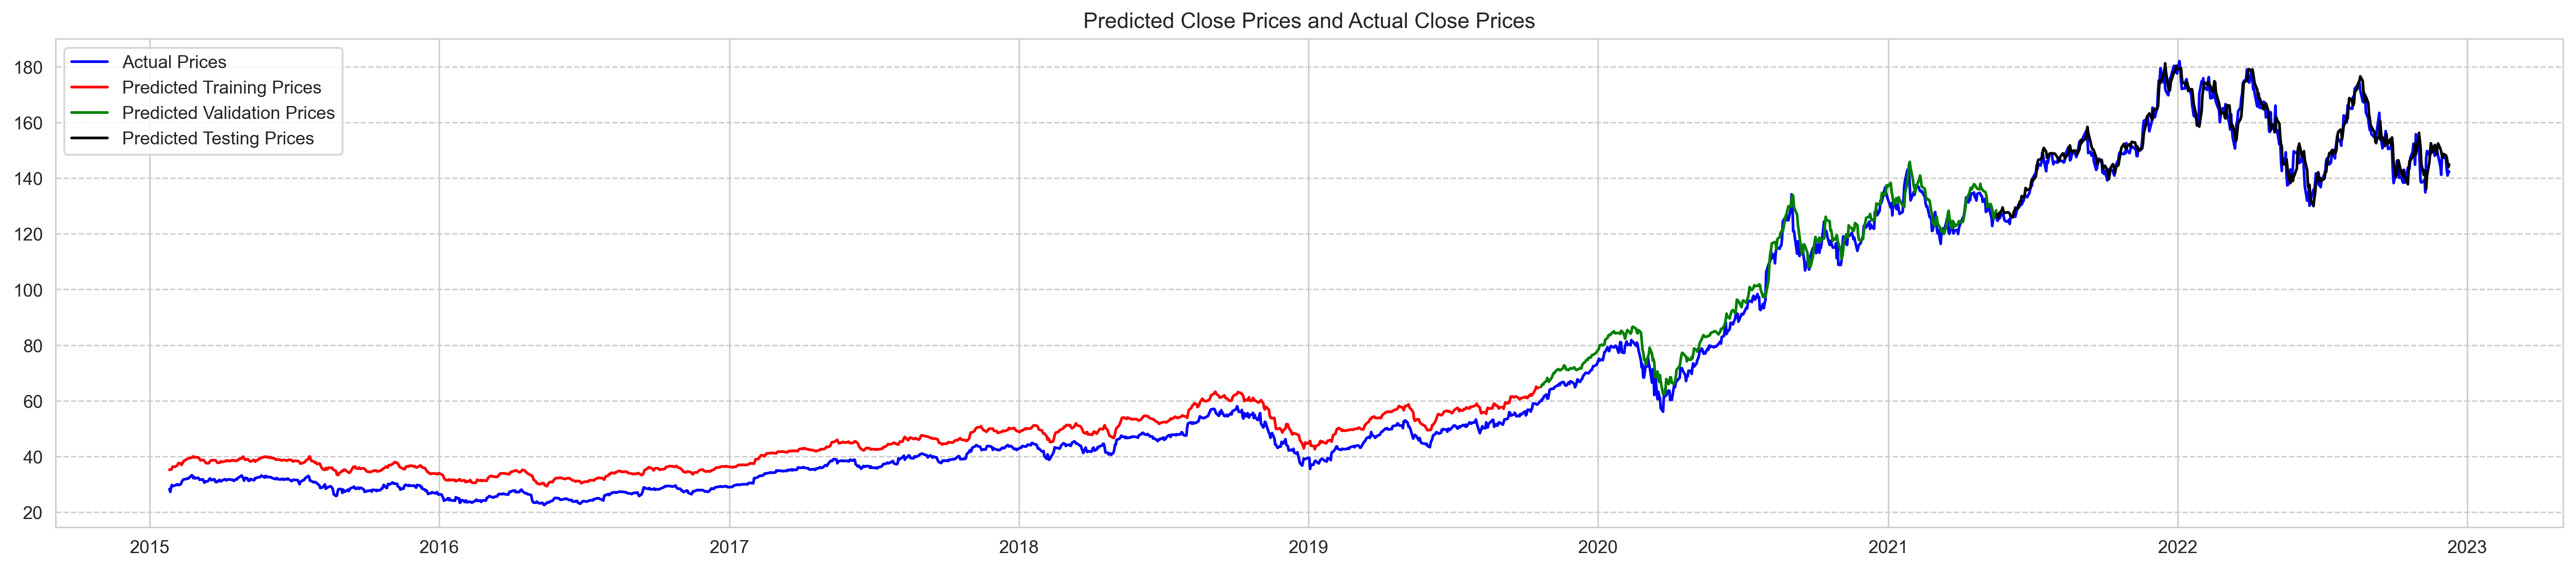

1186 396 396
1186 396 396
396
(1186, 15)
(1186, 15)
{'ae': 693.491, 'mape': 0.3665979, 'me': -0.038971577, 'mae': 0.03898207, 'mpe': -0.36652675, 'rmse': 0.04111455441947795, 'corr': 0.8818507295279422, 'minmax': 0.3665965795516968}
(396, 15)
{'ae': 180.64975, 'mape': 0.06321908, 'me': -0.0136476485, 'mae': 0.030412415, 'mpe': -0.031761214, 'rmse': 0.040880307856105406, 'corr': 0.9238647890030772, 'minmax': 0.06193476915359497}
(396, 15)
{'ae': 229.25957, 'mape': 0.04663015, 'me': -0.002894505, 'mae': 0.038595885, 'mpe': -0.0017192934, 'rmse': 0.04978048914796678, 'corr': 0.34715710106647074, 'minmax': 0.04510140419006348}


In [81]:
lookback = 15 # choose sequence length
pred_length = 15
normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =False, num_features = 20)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

dataset_train = MyDataLoader(x_train, y_train)
dataset_test = MyDataLoader(x_test, y_test)
dataset_val = MyDataLoader(x_val, y_val)

batch_size = 32
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

input_dim = len(x_train[0][0])
hidden_dim = 128
num_layers = 1
output_dim = pred_length
print(input_dim)
# model = AttentionalLSTM(input_dim, input_dim, hidden_dim, num_layers, output_dim)
# model = GRU(input_dim, hidden_dim, num_layers, output_dim)
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)

if train_on_gpu:
    model.cuda()
MAE_Loss = nn.L1Loss()
# criterion = torch.nn.MSELoss()
NLL_Loss = nn.GaussianNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
alpha = 100
gamma = 0.0001

model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     model.load_state_dict(torch.load('1_googd_model_without.pt'))

evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)

In [180]:
y_test.size()

torch.Size([398])

In [15]:
torch.cuda.empty_cache()